In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

sns.set(palette='Set2', font_scale=1.4)

## Cнижение размерностей



---
### Задача 1

В этой задаче мы попробуем применить PCA-разложение для уменьшения размерности данных в задаче классификации. Во многих случаях такая процедура позволяет выделить значимую информацию из датасета при незначительных потерях качества. А в лучшем случае мы избавимся от шумовых признаков и увеличим результат.

Будем использовать простой датасет для задачи классификации вин трех разных видов. На практике вам могут встретиться намного более объемные данные, которые имеют большую размерность (представьте, например, что вы закодировали большое число категориальных признаков с помощью one-hot).

Загрузим данные:

In [81]:
data = load_wine()
X, y = pd.DataFrame(data['data'],columns=data.feature_names), data['target']

Посмотрим на описание:

In [82]:
print(data['DESCR'])

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

Разделим данные на обучающую и тестовую выборки. 

Для того, чтобы сохранить пропорции каждого класса, используем аргумент `stratify`. 

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [84]:
(y_train == 1).sum()

42

Выполните стандартизацию данных. Объясните, почему она необходима в этом случае.

**Ответ:** Привести к одному масшабу ради нормальной дисперсии

In [85]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)

Визуализируйте проекцию выборки на первые две компоненты. Являются ли классы линейно разделимыми?

In [144]:
pca = PCA(n_components=2)
Y = pca.fit_transform(X_train_sc)
X_hat = pca.inverse_transform(Y)
c = np.hstack([np.zeros((y_train == 0).sum()), np.ones((y_train == 1).sum()), np.ones((y_train == 2).sum()) +np.ones((y_train == 2).sum())])

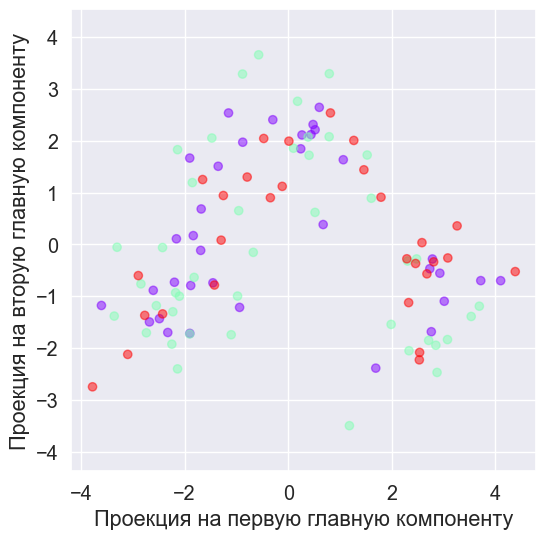

In [146]:
sns.set(font_scale=1.3)
plt.figure(figsize=(6, 6))
plt.scatter(Y[:, 0], Y[:, 1],c=c, alpha=0.5, cmap='rainbow')
plt.xlabel('Проекция на первую главную компоненту')
plt.ylabel('Проекция на вторую главную компоненту')
plt.axis('equal')
plt.show()

**Ответ:** нет

Постройте график зависимости качества логистической регрессии на тестовой выборке от числа компонент. Что можно наблюдать?

In [88]:
X_test_sc = scaler.transform(X_test)

In [89]:
accuracy  = []
for i in np.arange(1, 14, 1):
    model = LogisticRegression()
    pca = PCA(n_components=i)
    Y = pca.fit_transform(X_train_sc)
    model.fit(Y, y_train)
    X_test_pca = pca.transform(X_test_sc)
    accuracy.append(accuracy_score(y_test, model.predict(X_test_pca)))
    print(i, ' ', accuracy[i-1])

1   0.8611111111111112
2   0.9305555555555556
3   0.9583333333333334
4   1.0
5   1.0
6   0.9722222222222222
7   0.9583333333333334
8   0.9583333333333334
9   0.9583333333333334
10   0.9583333333333334
11   0.9722222222222222
12   0.9583333333333334
13   0.9861111111111112


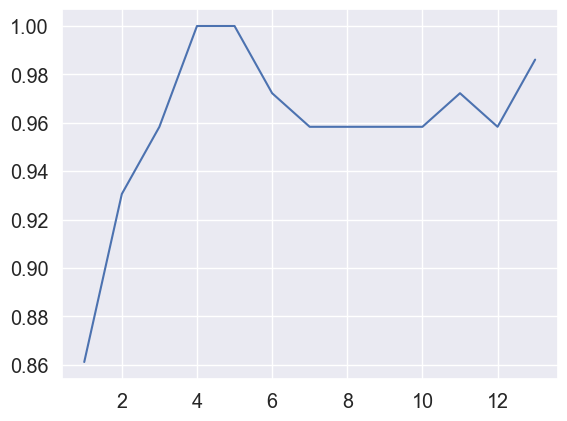

In [90]:
plt.plot(np.arange(1, 14, 1), accuracy)

**Ответ:** Из-за малого датасета точность может достигать 1.

Больше - не всегда лучше

Для лучшей комбинации компонент попробуйте логистическую регрессию с различными стратегиями многоклассовой классификации: `multinomial`, `OvO`, `OvR`. Как можно объяснить результаты?

Чтобы не было везде 1, я возьму 8, а не 4 компоненты

In [91]:
pca = PCA(n_components=8)
Y = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

In [92]:
model = LogisticRegression(multi_class='multinomial')
model.fit(Y, y_train)
accuracy_score(y_test, model.predict(X_test_pca))

0.9583333333333334

In [93]:
model = OneVsOneClassifier(LogisticRegression())
model.fit(Y, y_train)
accuracy_score(y_test, model.predict(X_test_pca))

1.0

In [94]:
model = OneVsRestClassifier(LogisticRegression())
model.fit(Y, y_train)
accuracy_score(y_test, model.predict(X_test_pca))

0.9722222222222222

**Ответ:** Практически не меняется

Попробуйте обучить обычную логистическую регрессию с Lasso-регуляризацией и выделить самые важные признаки. В чем отличие такого подхода от использования PCA-разложения?

In [132]:
X_ = pd.DataFrame(X_train_sc,columns=data.feature_names)
X_test_df = pd.DataFrame(X_test_sc,columns=data.feature_names)

In [135]:
model = LogisticRegression(l1_ratio=0.1, multi_class='multinomial')
model.fit(X_, y_train)
accuracy_score(y_test, model.predict(X_test_df))

0.9861111111111112

In [136]:
coefs = model.coef_

In [137]:
for i in range(len(data.feature_names)):
    print(data.feature_names[i], ' ', np.abs(coefs.T[i]).mean().round(3))

alcohol   0.622
malic_acid   0.211
ash   0.438
alcalinity_of_ash   0.37
magnesium   0.152
total_phenols   0.19
flavanoids   0.552
nonflavanoid_phenols   0.019
proanthocyanins   0.375
color_intensity   0.565
hue   0.507
od280/od315_of_diluted_wines   0.404
proline   0.636


Возьмём alcohol, proline, color_intensity, flavanois

In [138]:
X_new = X_.drop(['malic_acid','ash','alcalinity_of_ash','magnesium','total_phenols',
                'nonflavanoid_phenols','proanthocyanins','hue','od280/od315_of_diluted_wines',], axis = 1)

In [139]:
X_new_test = X_test_df.drop(['malic_acid','ash','alcalinity_of_ash','magnesium','total_phenols',
                'nonflavanoid_phenols','proanthocyanins','hue','od280/od315_of_diluted_wines',], axis = 1)

In [140]:
model = LogisticRegression(l1_ratio=0.1, multi_class='multinomial')
model.fit(X_new, y_train)
accuracy_score(y_test, model.predict(X_new_test))

0.9583333333333334

Какие есть преимущества и недостатки у снижения размерности перед обучением классификатора? Сделайте выводы по задаче.

**Вывод:** 

Лично у меня стало хуже. это может быть связано с малым датасетом